In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn


from datetime import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [2]:
# Load the filenames list. It's an ASCII file with either "targets_<station_id>.csv"
# or "data_<station_id>.csv"; ie, "data_54794.csv" and "targets_54794.csv" are both
# the ML training features and labels for USCRN Station #54794.
data_dir = "../data/stations/"
station_filenames_list = [
    filename for filename in os.listdir(path=data_dir)
    if filename!=".DS_Store"
]

# Read in the ASCII file that's just a list of strings of ACCLIMA station ID #'s.
file_path = "../data/acclima_stations_id_list.txt"
acclima_stations_list = pd.read_csv(file_path, header=None).iloc[:,0].values.tolist()

# Load features and targets into features and targets dictionaries, indexed
# by station ID number.
template_dict = {
    test_station_id : None
    for test_station_id in acclima_stations_list
}
features_dict,targets_dict = copy.deepcopy(template_dict), copy.deepcopy(template_dict)
del(template_dict)

# Loop through all the station data/target filenames and, if they're an ACCLIMA
# station, then load up the file into either the features dictionary or the
# targets dictionary.
for fname in station_filenames_list:

    station_id = fname.split("_")[1].split(".")[0]
    
    if station_id not in acclima_stations_list:
        continue
    
    elif "data" in fname:
        temp_feats_df = pd.read_csv(
            data_dir+fname,
            index_col="date"
        )
        temp_feats_df.index = pd.to_datetime(temp_feats_df.index, format="%Y-%m-%d %H:%M:%S")
        features_dict[station_id] = temp_feats_df

    elif "targets" in fname:
        temp_targs_df = pd.read_csv(
            data_dir+fname,
            index_col="date"
        )
        temp_targs_df.index = pd.to_datetime(temp_targs_df.index, format="%Y-%m-%d %H:%M:%S")
        targets_dict[station_id] = temp_targs_df

# Filter out the bad dates from the Port Aransas USCRN station data.

# Got the following station ID info from this URL:
# https://mesonet.agron.iastate.edu/sites/site.php?station=23906&network=USCRN
port_aransas_stat_id = "23906"
feats_df_port_aransas = features_dict[port_aransas_stat_id]
targs_df_port_aransas = targets_dict[port_aransas_stat_id]


# Got the following date-exclusion idea from here:
# https://stackoverflow.com/questions/55680603/pandas-filter-on-datetimeindex-by-excluding-date-range
exclusion_dates = pd.date_range(start="2019-08-01", end="2019-09-01")

features_dict[port_aransas_stat_id] = feats_df_port_aransas.loc[~feats_df_port_aransas.index.isin(exclusion_dates)]

targets_dict[port_aransas_stat_id] = targs_df_port_aransas.loc[~targs_df_port_aransas.index.isin(exclusion_dates)]

# Concatenate anomaly data for ML

In [3]:
# Make a blank dictionary in which to store the scaled features. Only include
# the stations that have all sensor depths for all three soil moisture sensors
# (ie, holes) present. If the station is missing depths/holes (ie, if the
# station does NOT have all 3x5=15 sensors present), then skip that station.
# There are only 7 such ACCLIMA stations.
scaled_feats_dict = {
    stat_id : None
    for stat_id in acclima_stations_list
    if features_dict[stat_id].shape[1]==15
}

for stat_id in acclima_stations_list:
    
    df_to_scale = copy.deepcopy(features_dict[stat_id]).drop(columns=["p_official", "t_official"])
    
    if df_to_scale.shape[1]==15:
        df_to_scale[(df_to_scale == -99999)] = pd.NA
        df_to_scale = df_to_scale.interpolate(method="time", axis=0)
        df_to_scale = df_to_scale.fillna(method="bfill", axis=0)
        scaler = StandardScaler(with_mean=True)
        feats_scaled_array = scaler.fit_transform(df_to_scale)
        feats_scaled_df = pd.DataFrame(data=feats_scaled_array, index=df_to_scale.index, columns=df_to_scale.columns)
#         if np.isnan(feats_scaled_array).sum() == 0:
        scaled_feats_dict[stat_id] = copy.deepcopy(feats_scaled_df)
    else:
        continue

# Load up the list of the stations that made it through the scaling process.
final_station_ids_list = [stat_id for stat_id in scaled_feats_dict.keys()]        

features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]

scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)

combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)

# This takes a COUPLE MINUTES TO RUN. So, only re-run if necessary!!
# # combined_scaledfeats_targs_df.to_csv("../data/combined_scaledfeats_targs_df.csv")

combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -15:]
ml_1D_targs_series = ml_targs_df.sum(axis=1)
ml_1D_targs_series[ml_1D_targs_series > 1] = 1
ml_1D_targs_series = ml_1D_targs_series.astype("int")

# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

In [4]:
# Calculate the percentage of the ML-ready data that are anomalies
percentage_anomalies =\
    np.round(100*ml_1D_targs_series.sum()/ml_1D_targs_series.shape[0], 2)
print(f"{percentage_anomalies}% of the data are anomalies.")

11.62% of the data are anomalies.


# Attempt some ML! Yewwwwww!

In [98]:
X = ml_feats_df.values
y = ml_1D_targs_series.values

# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Initialize a stratified 5-fold cross-validation object.  Make certain that it
# randomly shuffles the data. AND, since it's randomly shuffling the data, make
# certain that its random state is set to 7 (an arbitrary choice: it simply
# needs to have a constant random state seed).
stratified_kfold_generator = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Iterate through each of the splits and train/test both classifiers. We will 
# store the predictions in the following lists, "classfication predictions_rf" 
# and "classfication predictions_xgb".
classification_predictions_rf = list()
for idx, (train, test) in enumerate(stratified_kfold_generator.split(X, y)):
    
    print(idx)
    
    # Fit the classifiers to the training data. This erases the training from any
    # previous iteration of the loop.
    rf_classifier.fit(X[train], y[train].ravel())

    # Have the newly trained classifiers predict the classes of the withheld testing data.
    y_predicted_rf = rf_classifier.predict(X[test])

    # Add the true class labels and the predicted class labels to the storage lists.
    classification_predictions_rf.append((y[test].ravel(), y_predicted_rf.ravel()))

0
1
2
3
4


/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


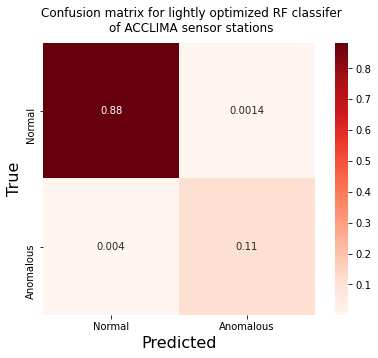

In [97]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer\nof ACCLIMA sensor stations")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


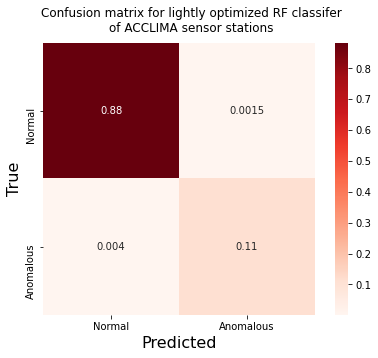

In [82]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer\nof ACCLIMA sensor stations")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


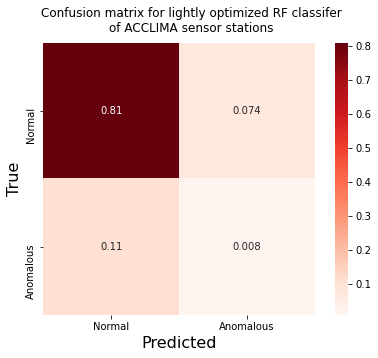

In [74]:
def calculate_normalized_conf_matrix(classification_predictions):
    cf = np.zeros((2,2))
    for y_true, y_pred in classification_predictions:
        cf += confusion_matrix(y_true, y_pred)
    return cf/cf.sum()

class_labels_list = ["Normal", "Anomalous"]

# Loop through the cached predictions and calculate the confusion matrices for
# both classifiers.
cf_rf = calculate_normalized_conf_matrix(classification_predictions_rf)

# Initialize figure and axes objects in order to plot the two confusion matrices.
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Plot the random forest confusion matrix.
seaborn.heatmap(
    cf_rf, cmap="Reds", annot=cf_rf, square=True, cbar=True,
    xticklabels=class_labels_list, yticklabels=class_labels_list,
    ax=ax
)

# Add labels to the x-axis and the y-axis.
ax.set_xlabel("Predicted", fontsize=16)
ax.set_ylabel("True", fontsize=16)

# Add a title to the figure.
fig.suptitle("Confusion matrix for lightly optimized RF classifer\nof ACCLIMA sensor stations")

plt.savefig("randomforest_confusion_matrix.png", dpi=300)

# Display the figure.
fig.show()

In [75]:
cf_rf

# # Previous cf_rf w/out Port Aransas filtered.
# array([[0.88232525, 0.00146891],
#        [0.00401041, 0.11219543]])

array([[0.80952394, 0.07426535],
       [0.10816656, 0.00804415]])

In [76]:
print("Accuracy:")
print(str(np.round(100*(cf_rf[0,0]+cf_rf[1,1]), 2))+"%")

# # Previous accuracy w/out Port Aransas filtered.
# Accuracy:
# 99.45%

Accuracy:
81.76%


In [77]:
1-(cf_rf[1,0]/cf_rf[1,1])

# # Previous percentage of correctly detected anomalies w/out Port Aransas filtered.
# 0.9642551447274832

-12.446611737010258

# VERIFY THAT THIS IS PRODUCING SANE RESULTS

In [102]:
y_true, y_pred = classification_predictions_rf[0]

In [103]:
# for y_true, y_pred in classification_predictions_rf:
#     print(y_true.sum(), y_pred.sum())

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


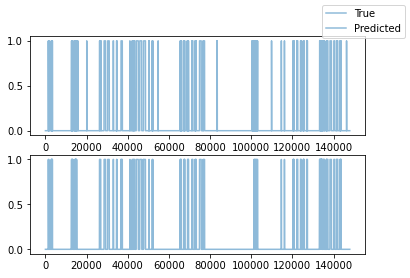

In [104]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(y_true, label="True", alpha=0.5 )
ax[1].plot(y_pred, label="Predicted", alpha=0.5 )
fig.legend()
fig.show()

In [105]:
# for y_true, y_pred in classification_predictions_rf:
#     fig, ax = plt.subplots(2, 1)
#     ax[0].plot(y_true, label="True", alpha=0.5 )
#     ax[1].plot(y_pred, label="Predicted", alpha=0.5 )
#     fig.legend()
#     fig.show()

In [106]:
# num_ticks = 8
# replacement_x_ticks = [i*int(idxs_y_predict.max()/(num_ticks-1)) for i in range(num_ticks)]
# replacement_x_tick_labels = [label/24/365 for label in replacement_x_ticks]

In [148]:
x_tick_labels = [item.get_text() for item in ax[1].get_xticklabels() if item.get_text()[0]!="-"]
x_tick_labels[0].split("-")

['−20000']

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


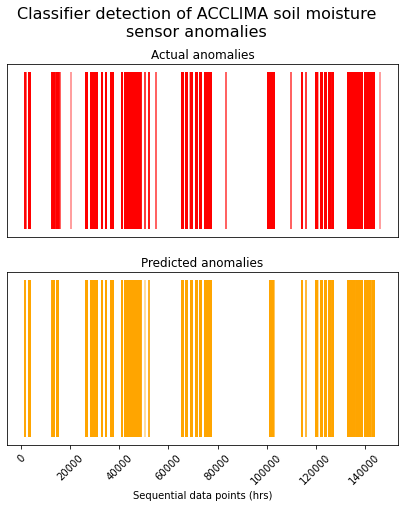

In [161]:
idxs_y_true = np.where(y_true==1)[0]
idxs_y_predict = np.where(y_pred==1)[0]

alpha = 0.5

fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
ymin, ymax = [0], [1]

ax[0].vlines(
    idxs_y_true,
    ymin, 
    ymax,
    label="True", 
    color="r", 
    alpha=alpha
)
ax[0].tick_params(axis="x", bottom=False)
ax[0].tick_params(axis="y", left=False, labelleft=False)
ax[0].set_title("Actual anomalies")


ax[1].vlines(idxs_y_predict, ymin, ymax, label="Predicted", color="orange", alpha=alpha)
ax[1].tick_params(axis="y", left=False, labelleft=False)

ax[1].set_xticklabels(x_tick_labels, rotation=45)
ax[1].set_xlabel("Sequential data points (hrs)")

ax[1].set_title("Predicted anomalies")

# x_tick_labels = [item.get_text() for item in ax[1].get_xticklabels()]
# # ax[1].set_xticks(idxs_y_predict)

# fig.legend(loc="upper right", shadow=False, fancybox=True)

fig.suptitle("Classifier detection of ACCLIMA soil moisture\nsensor anomalies", fontsize=16, y=0.995,)

# plt.tight_layout()
fig.savefig("../plots/test.pdf")
fig.show()

# LOOP OVER ALL FOLDS AND PLOT

/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/garrettgraham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Matplo

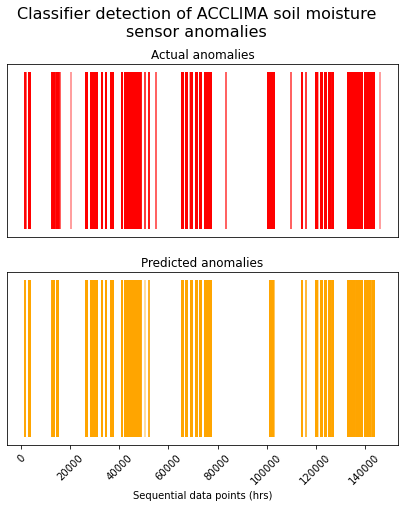

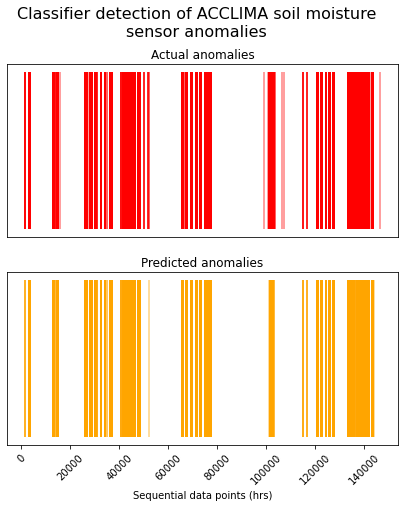

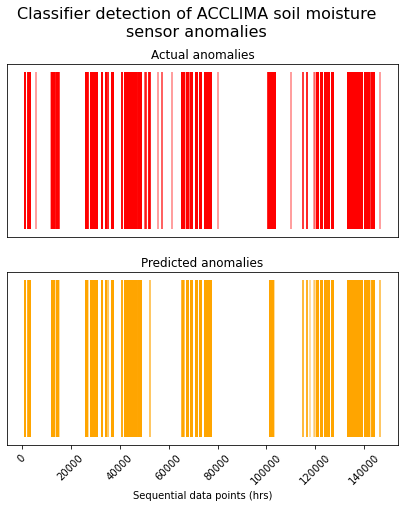

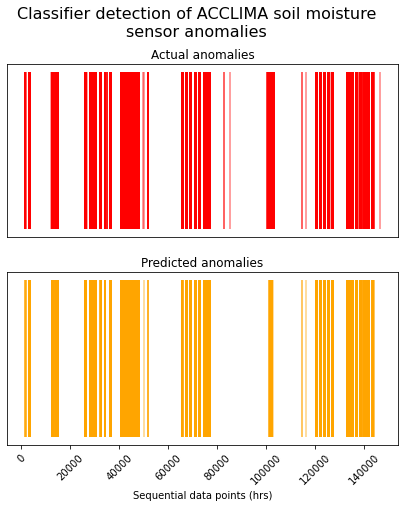

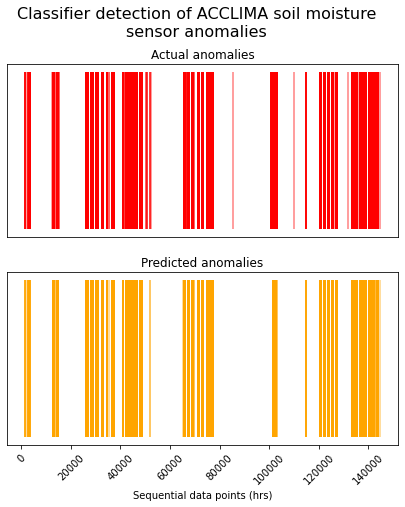

In [162]:
for idx, (y_true, y_pred) in enumerate(classification_predictions_rf):

    idxs_y_true = np.where(y_true==1)[0]
    idxs_y_predict = np.where(y_pred==1)[0]

    alpha = 0.5

    fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    ymin, ymax = [0], [1]

    ax[0].vlines(
        idxs_y_true,
        ymin, 
        ymax,
        label="True", 
        color="r", 
        alpha=alpha
    )
    ax[0].tick_params(axis="x", bottom=False)
    ax[0].tick_params(axis="y", left=False, labelleft=False)
    ax[0].set_title("Actual anomalies")


    ax[1].vlines(idxs_y_predict, ymin, ymax, label="Predicted", color="orange", alpha=alpha)
    ax[1].tick_params(axis="y", left=False, labelleft=False)

    ax[1].set_xticklabels(x_tick_labels, rotation=45)
    ax[1].set_xlabel("Sequential data points (hrs)")

    ax[1].set_title("Predicted anomalies")

    # x_tick_labels = [item.get_text() for item in ax[1].get_xticklabels()]
    # # ax[1].set_xticks(idxs_y_predict)

    # fig.legend(loc="upper right", shadow=False, fancybox=True)

    fig.suptitle("Classifier detection of ACCLIMA soil moisture\nsensor anomalies", fontsize=16, y=0.995,)

    # plt.tight_layout()
    fig.savefig("../plots/time_series_actual_v_predict/time_series_actual_v_predict_0"+str(idx)+".pdf")
    fig.show()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%%%%%%%%    IN PROGRESS    %%%%%%%%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# Identify single station with many anomalies to utilize as a plotting candidate

In [47]:
for station_idx, target_df in targets_dict.items(): 
    if target_df.shape[1] == 15:
        print("station ID:", station_idx)
        print("number of errors:\n", target_df.sum().sum())
        print("##################################################")

station ID: 03054
number of errors:
 682
##################################################
station ID: 03728
number of errors:
 15
##################################################
station ID: 03758
number of errors:
 0
##################################################
station ID: 04127
number of errors:
 15208
##################################################
station ID: 04141
number of errors:
 34
##################################################
station ID: 04236
number of errors:
 0
##################################################
station ID: 04990
number of errors:
 13510
##################################################
station ID: 04994
number of errors:
 66509
##################################################
station ID: 13301
number of errors:
 6303
##################################################
station ID: 23906
number of errors:
 9081
##################################################
station ID: 23909
number of errors:
 5612
####################################

### Use these and plot the different time series, highlighting the ground truth

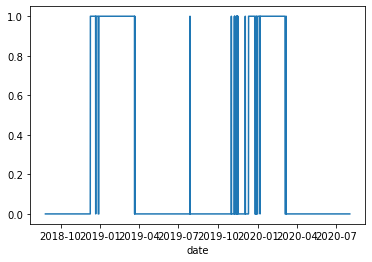

In [164]:
# predict_station_id = "04990"
# predict_station_id = "23909"
predict_station_id = "94995"


features_df = copy.deepcopy(features_dict[predict_station_id])
target_df = copy.deepcopy(targets_dict[predict_station_id])

target_series = target_df.sum(axis=1)
target_series[target_series > 1] = 1

# Plot the entire time course to check 
seaborn.lineplot(x=target_series.index, y=target_series.values,)
plt.show()

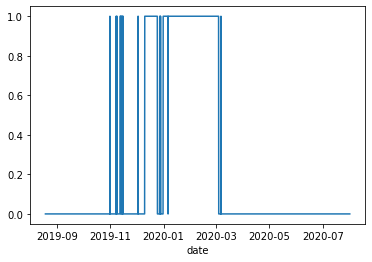

In [165]:
plot_start_prcnt = 50
plot_start_index = int(np.ceil(plot_start_prcnt*0.01*target_series.shape[0]))
seaborn.lineplot(x=target_series.index[plot_start_index:], y=target_series.values[plot_start_index:])
plt.show()

In [167]:
features_df.

,sw1005,sw1010,sw1020,sw1050,sw1100,sw2005,sw2010,sw2020,sw2050,sw2100,sw3005,sw3010,sw3020,sw3050,sw3100,p_official,t_official
date,,,,,,,,,,,,,,,,,
2018-08-26 16:00:00,0.000,0.000,0.000,0.457,0.541,0.000,0.016,0.000,0,0.642,0.457,0.457,0.013,0.410,0.354,NaN,NaN
2018-08-26 17:00:00,0.000,0.000,0.000,0.502,0.580,0.000,0.016,0.000,0,0.587,0.454,0.444,0.013,0.420,0.351,NaN,NaN
2018-08-26 18:00:00,0.000,0.000,0.000,0.514,0.590,0.000,0.000,0.000,0,0.583,0.455,0.441,0.013,0.421,0.350,NaN,NaN
2018-08-26 19:00:00,0.000,0.000,0.000,0.496,0.595,0.000,0.000,0.000,0,0.560,0.451,0.449,0.013,0.418,0.357,NaN,NaN
2018-08-26 20:00:00,0.000,0.000,0.000,0.507,0.571,0.000,0.000,0.000,0,0.567,0.447,0.456,0.013,0.422,0.355,0.0,27.227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 19:00:00,0.373,0.416,0.415,0.000,0.585,0.371,0.000,0.423,0,0.000,0.389,0.415,0.021,0.075,0.355,0.0,26.625
2020-07-31 20:00:00,0.378,0.414,0.416,0.000,0.618,0.369,0.000,0.425,0,0.000,0.390,0.412,0.021,0.076,0.356,0.0,26.912
2020-07-31 21:00:00,0.371,0.423,0.409,0.000,0.600,0.370,0.000,0.426,0,0.000,0.377,0.409,0.021,0.077,0.355,0.0,27.068


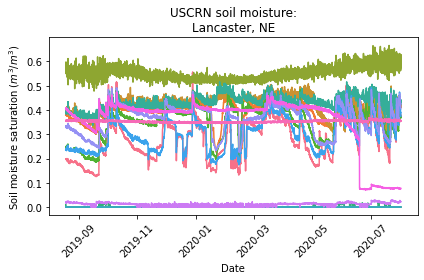

In [178]:
seaborn.lineplot(
    data=features_df.iloc[plot_start_index:,:-2],
    dashes=False,
    legend=False,
)
plt.ylabel("Soil moisture saturation ($m^{3}/m^{3}$)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.title("USCRN soil moisture:\nLancaster, NE")
plt.tight_layout()
plt.savefig("../plots/Lancaster_time_series_raw.pdf")
plt.show()

# Train on everything but single station and then generate predictions for it

In [160]:
# Load up the list of the stations that made it through the scaling process.
final_station_ids_list = [
    stat_id 
    for stat_id in scaled_feats_dict.keys() 
    if stat_id!=predict_station_id
]        
features_dfs_list = [scaled_feats_dict[station_id] for station_id in final_station_ids_list]
targets_dfs_list = [targets_dict[station_id] for station_id in final_station_ids_list]
scaled_feats_df = pd.concat(features_dfs_list, axis=0)
targs_df = pd.concat(targets_dfs_list, axis=0)
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -15:]
ml_1D_targs_series = ml_targs_df.sum(axis=1)
ml_1D_targs_series[ml_1D_targs_series > 1] = 1
ml_1D_targs_series = ml_1D_targs_series.astype("int")

# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

X_train = ml_feats_df.values
y_train = ml_1D_targs_series.values

# Initialize a random forest (RF) classifier object with the best hyperparameter 
# sets from the grid search.
rf_classifier = RandomForestClassifier(n_jobs=-1)

# Fit the classifiers to the training data. This erases the training from any
# previous iteration of the loop.
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

#### Isolate station of interest for prediction

In [161]:
scaled_feats_df = copy.deepcopy(scaled_feats_dict[predict_station_id])
targs_df = copy.deepcopy(targets_dict[predict_station_id])
combined_scaledfeats_targs_df = pd.concat([scaled_feats_df,targs_df], axis=1)
combined_scaledfeats_targs_NONAN_df = combined_scaledfeats_targs_df.dropna(how="any", axis=0)

# Re-isolate the targets and then combine them into a 1-D pd.series. 
# Whenever a row has at least one anomaly, then we will collapse that row's 
# values to a single value of 1. Rows with no anomalies shall be labeled as 0.
ml_targs_df = combined_scaledfeats_targs_NONAN_df.iloc[:, -15:]
ml_1D_targs_series = ml_targs_df.sum(axis=1)
ml_1D_targs_series[ml_1D_targs_series > 1] = 1
ml_1D_targs_series = ml_1D_targs_series.astype("int")

# Re-isolate the ML-ready features.
ml_feats_df = combined_scaledfeats_targs_NONAN_df.iloc[:, :15]

X_predict = ml_feats_df.values
y_predict = ml_1D_targs_series.values

# Have the newly trained classifiers predict the classes of the withheld testing data.
y_predicted_rf = rf_classifier.predict(X_predict)

In [162]:
X_predict.shape

(16686, 15)

In [163]:
y_predicted_rf.shape

(16686,)

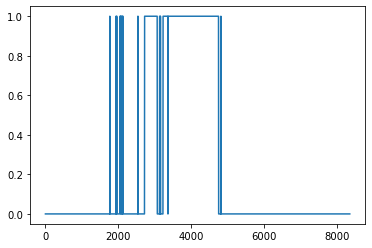

In [164]:
seaborn.lineplot(data=y_predict[plot_start_index:])
plt.show()

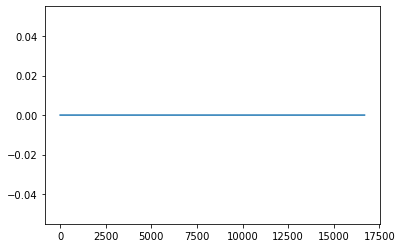

In [165]:
seaborn.lineplot(data=y_predicted_rf)
plt.show()

In [103]:
target_series.index[plot_start_index:].shape

(9746,)

In [107]:
plot_start_index

9747

In [104]:
y[plot_start_index:].shape

(710055,)

In [102]:
seaborn.lineplot(x=target_series.index[plot_start_index:], y=y[plot_start_index:])
plt.show()

ValueError: arrays must all be same length